In [75]:
import matplotlib.pyplot as plt
import numpy  as np
import pandas as pd

%matplotlib inline
plt.style.use('physics')

plt.rcParams['axes.grid'       ]  = False
plt.rcParams['xtick.labelsize' ]  = 14
plt.rcParams['ytick.labelsize' ]  = 14
plt.rcParams['axes.labelsize'  ]  = 14
plt.rcParams['legend.fancybox' ]  = False

pd.options.mode.chained_assignment = None

import binopt

from scipy import special as sp

In [84]:
df = pd.read_hdf('../../data-driven/data/hgg-double-fake-trees-training-2017.h5')
df.columns

Index([u'Y', u'Z', u'avg_et', u'avg_pt', u'cr_region', u'diff_et',
       u'dijet_LeadJPt', u'dijet_Mjj', u'dijet_SubJPt', u'dijet_Zep',
       u'dijet_abs_dEta', u'dijet_dipho_dphi', u'dijet_dipho_dphi_trunc',
       u'dijet_dphi', u'dijet_leadEta', u'dijet_minDRJetPho', u'dijet_mva',
       u'dijet_subleadEta', u'dipho_PToM', u'dipho_cosphi', u'dipho_leadEt',
       u'dipho_leadEta', u'dipho_leadIDMVA', u'dipho_leadPt',
       u'dipho_lead_elveto', u'dipho_lead_sieie', u'dipho_mass', u'dipho_mva',
       u'dipho_subleadEt', u'dipho_subleadEta', u'dipho_subleadIDMVA',
       u'dipho_subleadPt', u'dipho_sublead_elveto', u'dipho_sublead_sieie',
       u'eta_cat', u'fail_id', u'isvbf', u'leadPho_PToM', u'lead_eta_cat',
       u'm_sideband', u'max_eta', u'max_id', u'min_eta', u'min_id',
       u'n_jet_30', u'pass_id', u'sample', u'sublPho_PToM', u'subl_eta_cat',
       u'weight', u'weight_bins'],
      dtype='object')

In [ ]:
def vbf_presel(data):
    return (
        (data["leadPho_PToM"       ]> (1/3.0))&
        (data["sublPho_PToM"       ]> (1/4.0))&
        (data["dijet_LeadJPt"      ]> 30     )& 
        (data["dijet_SubJPt"       ]> 20     )&
        (data["dijet_Mjj"          ]> 250    )&
        (data["dipho_mass"         ]> 100    )&
        (data["dipho_mass"         ]< 180    ))

df = df[vbf_presel(df)]

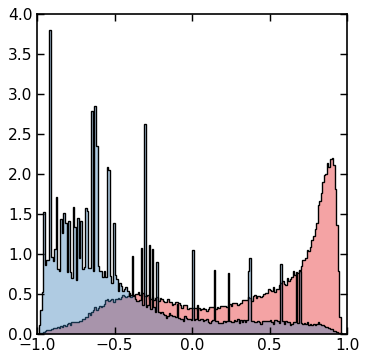

In [91]:
plt.figure(figsize=(5,5))

plt.hist(df[df.Y==1].dijet_mva,bins=200, range=[-1,1], 
         alpha=0.4, weights=df[df.Y==1].weight, 
         histtype='stepfilled',lw=1, normed=1)
plt.hist(df[df.Y==1].dijet_mva, bins=200, range=[-1,1], 
         weights=df[df.Y==1].weight,
         color='k' ,histtype='step',lw=1.2, normed=1)

plt.hist(df[df.Y==0].dijet_mva,bins=200, range=[-1,1], 
         alpha=0.4, weights=df[df.Y==0].weight, 
         histtype='stepfilled',lw=1, normed=1)
plt.hist(df[df.Y==0].dijet_mva, bins=200, range=[-1,1], 
         weights=df[df.Y==0].weight,
         color='k' ,histtype='step',lw=1.2, normed=1)

# plt.yscale('log')
plt.show()

In [100]:
X = df.dijet_mva
Y = df.Y
W = df.weight *36.0

In [101]:
from scipy.interpolate import interp1d
    
class empirical_cdf(object):
    def __init__(self, x, weights=None):
        if weights is None:
            weights = np.ones(x.shape[0])
        self._data = np.column_stack([x,weights])
        self._data = self._data[self._data[:,0].argsort()]
        x = self._data[:,0]
        y = self._data[:,1].cumsum()/self._data[:,1].sum()
        self.fcn = interp1d(x,y, bounds_error=False)
    def fcn(self):
        return self.fcn

In [102]:
fs = empirical_cdf(X[Y==1],weights=W[Y==1])
fb = empirical_cdf(X[Y==0],weights=W[Y==0])

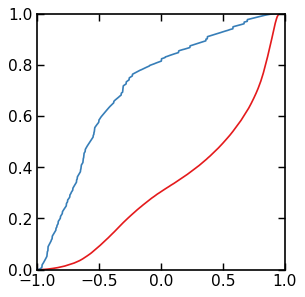

In [103]:
plt.figure(figsize=(4,4))
t = np.linspace(-1,1,1000)
plt.plot(t,fs.fcn(t), '-')
plt.plot(t,fb.fcn(t), '-')
plt.show()

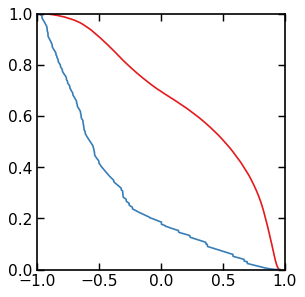

In [104]:
plt.figure(figsize=(4,4))
t = np.linspace(-1,1,1000)
plt.plot(t,1.0 - fs.fcn(t), '-')
plt.plot(t,1.0 - fb.fcn(t), '-')
plt.show()

$n_k = 1/ N^m \sum_{x_i \in R^m} I(y_i = k)$

$index = \sum_{k=0}^{K-1} n_k (1 - n_k) = 1 - \sum_{k=0}^{K-1} n_k^2$

In [193]:
# def significance(s,b, berr):
#     return  np.sqrt (2.*( (s + b + berr)*np.log(1.+s/(b+berr))-s))

def significance(s,b):
    return  s/np.sqrt (s + b)


gain_tree  = []
boundaries = [] 
def build_tree(x,y,w, iteration=0, gain=0):
    s_ = w[y==1].sum()
    b_ = w[y==0].sum()
    print iteration,' stat : ', s_," : ", b_
    z_node = significance(s_,b_,0.1)
    z_l = lambda t: significance(s_*fs.fcn(t),b_*fb.fcn(t))
    z_r = lambda t: significance(s_*(1-fs.fcn(t)),b_*(1-fb.fcn(t)),0.1)
    def gain_(x):
        return z_l(x)**2 + z_r(x)**2 - z_node**2
    max_x = scipy.optimize.minimize_scalar(lambda t: -gain_(t), bounds=(-1,1), method='bounded')
    gain_tree.append(max_x.fun)
    boundaries.append(max_x.x )
    if iteration > 4:
        return gain
    else:
        x_r = x[x>max_x.x]
        x_l = x[x<max_x.x]
        
        y_r = y[x>max_x.x]
        y_l = y[x<max_x.x]
        
        w_r = w[x>max_x.x]
        w_l = w[x<max_x.x]
        build_tree(x_r,y_r,w_r, iteration+1, max_x.fun)
        build_tree(x_l,y_l,w_l, iteration+1, max_x.fun)
    
build_tree(X,Y,W)

print gain_tree
print boundaries

0  stat :  47.4259267307  :  32564.5326879
1  stat :  10.088444998  :  211.216863891
2  stat :  10.088444998  :  211.216863891
3  stat :  10.088444998  :  211.216863891
4  stat :  10.088444998  :  211.216863891
5  stat :  10.088444998  :  211.216863891
5  stat :  0  :  0
4  stat :  0  :  0
5  stat :  0  :  0
5  stat :  0  :  0
3  stat :  0  :  0
4  stat :  0  :  0
5  stat :  0  :  0
5  stat :  0  :  0
4  stat :  0  :  0
5  stat :  0  :  0
5  stat :  0  :  0
2  stat :  0  :  0
3  stat :  0  :  0
4  stat :  0  :  0
5  stat :  0  :  0
5  stat :  0  :  0
4  stat :  0  :  0
5  stat :  0  :  0
5  stat :  0  :  0
3  stat :  0  :  0
4  stat :  0  :  0
5  stat :  0  :  0
5  stat :  0  :  0
4  stat :  0  :  0
5  stat :  0  :  0
5  stat :  0  :  0
1  stat :  37.3374817328  :  32353.315824
2  stat :  0  :  0
3  stat :  0  :  0
4  stat :  0  :  0
5  stat :  0  :  0
5  stat :  0  :  0
4  stat :  0  :  0
5  stat :  0  :  0
5  stat :  0  :  0
3  stat :  0  :  0
4  stat :  0  :  0
5  stat :  0  :  0
5 

In [190]:
np.unique(boundaries)

array([ 0.7716,  0.8369,  0.8547,  0.8885])

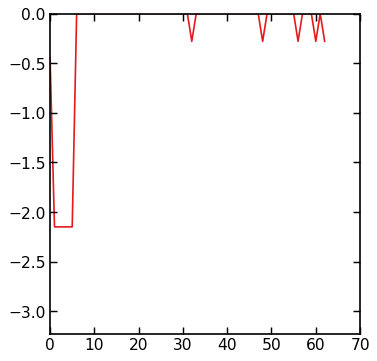

In [191]:
plt.figure(figsize=(5,5))  
plt.plot(range(len(gain_tree)), gain_tree)
plt.ylim([1.5*min(gain_tree),2*max(gain_tree)])
plt.legend()
plt.show()

In [138]:
import scipy
def signif(x):
    return fs.fcn(x)**2/(fb.fcn(x) + 1)
max_x = scipy.optimize.fmin(lambda t: -signif(t), 0.5)
max_x

Optimization terminated successfully.
         Current function value: -0.499302
         Iterations: 18
         Function evaluations: 36


array([ 0.9531])

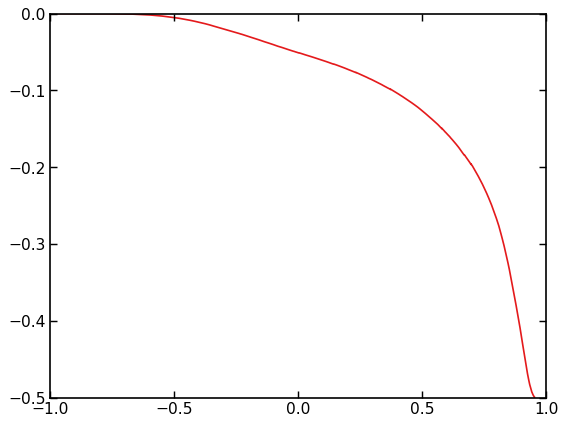

In [132]:
t = np.linspace(-1,1,5000)
plt.plot(t,-signif(t), '-', label='left')